# Clasificación de los Mejores Jugadores de la Premier League (2024–2025)
###  Autores: Alberto Carlos Navarrete Garcia And Angel Guillermo Lopez Delgado 
###  Curso: Machine Learning - Unit 2
###  Dataset: epl_player_stats_24_25.csv

---

### Dataset Selection

Este proyecto tiene como objetivo clasificar a los jugadores de la Premier League en **Top Players** (rendimiento ofensivo destacado) y **No Top Players**, usando como criterio la suma de **Goles + Asistencias**.

- Se eligió un dataset con más de 8 características (hay 30+ después de limpieza).
- La variable objetivo es **`TopPlayer`**, definida como `1` si el jugador está en el top 25% en goles+asistencias, y `0` en caso contrario.
- Es un problema realista, relevante y completamente resoluble mediante algoritmos de clasificación.


#### Import Libraries

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)


### Loading and displaying data

In [153]:
df = pd.read_csv('epl_player_stats_24_25.csv')
df.head()

,Player Name,Club,Nationality,Position,Appearances,Minutes,Goals,Assists,Shots,Shots On Target,...,Fouls,Yellow Cards,Red Cards,Saves,Saves %,Penalties Saved,Clearances Off Line,Punches,High Claims,Goals Prevented
0,Ben White,Arsenal,England,DEF,17,1198,0,2,9,12,...,10,2,0,0,0%,0,0,0,0,0.0
1,Bukayo Saka,Arsenal,England,MID,25,1735,6,10,67,2,...,15,3,0,0,0%,0,0,0,0,0.0
2,David Raya,Arsenal,Spain,GKP,38,3420,0,0,0,0,...,1,3,0,86,72%,0,0,8,53,2.1
3,Declan Rice,Arsenal,England,MID,35,2833,4,7,48,18,...,21,5,1,0,0%,0,0,0,0,0.0
4,Ethan Nwaneri,Arsenal,England,MID,26,889,4,0,24,0,...,9,1,0,0,0%,0,0,0,0,0.0


In [154]:

# Eliminación segura de columnas irrelevantes o específicas de porteros
columns_to_drop = [
    "Red Cards", "Saves", "Saves %", "Penalties Saved",
    "Clearances Off Line", "Punches", "High Claims",
    "Goals Conceded", "xGoT Conceded", "Own Goals","Goals Prevented"
]

df.drop(columns=columns_to_drop, inplace=True, errors="ignore")
df_clean = df.copy()



In [155]:
df.head()

,Player Name,Club,Nationality,Position,Appearances,Minutes,Goals,Assists,Shots,Shots On Target,...,Blocks,Tackles,Ground Duels,gDuels Won,gDuels %,Aerial Duels,aDuels Won,aDuels %,Fouls,Yellow Cards
0,Ben White,Arsenal,England,DEF,17,1198,0,2,9,12,...,6,20,231,116,50%,16,5,31%,10,2
1,Bukayo Saka,Arsenal,England,MID,25,1735,6,10,67,2,...,14,29,58,34,59%,45,23,51%,15,3
2,David Raya,Arsenal,Spain,GKP,38,3420,0,0,0,0,...,0,0,0,0,0%,0,0,0%,1,3
3,Declan Rice,Arsenal,England,MID,35,2833,4,7,48,18,...,5,53,342,121,35%,26,10,39%,21,5
4,Ethan Nwaneri,Arsenal,England,MID,26,889,4,0,24,0,...,0,11,0,0,0%,0,0,0%,9,1


### Data structure

In [156]:
df.shape  # Ver cantidad de filas y columnas
df.dtypes  # Tipos de datos por columna
df.describe(include='all').T  # Estadísticas generales
df.isnull().sum().sort_values(ascending=False)  # Valores nulos
(df == 0).sum().sort_values(ascending=False)  # Columnas con muchos ceros

Carries Ended with Goal      470
Carries Ended with Assist    437
Hit Woodwork                 397
Assists                      362
Carries Ended with Shot      334
Through Balls                323
Successful Crosses           321
Carries Ended with Chance    302
Goals                        301
Blocks                       299
Crosses                      281
Offsides                     280
Shots On Target              279
Big Chances Missed           278
aDuels Won                   268
fThird Passes                267
Progressive Carries          267
Carries                      267
Possession Won               267
Successful fThird Passes     267
Interceptions                267
Ground Duels                 267
gDuels Won                   267
Successful Passes            267
Passes                       267
Aerial Duels                 267
Clean Sheets                 255
Dispossessed                 152
Yellow Cards                 143
Fouls                        110
Shots     

### Create target variable

In [157]:
df.columns

Index(['Player Name', 'Club', 'Nationality', 'Position', 'Appearances',
       'Minutes', 'Goals', 'Assists', 'Shots', 'Shots On Target',
       'Conversion %', 'Big Chances Missed', 'Hit Woodwork', 'Offsides',
       'Touches', 'Passes', 'Successful Passes', 'Passes%', 'Crosses',
       'Successful Crosses', 'Crosses %', 'fThird Passes',
       'Successful fThird Passes', 'fThird Passes %', 'Through Balls',
       'Carries', 'Progressive Carries', 'Carries Ended with Goal',
       'Carries Ended with Assist', 'Carries Ended with Shot',
       'Carries Ended with Chance', 'Possession Won', 'Dispossessed',
       'Clean Sheets', 'Clearances', 'Interceptions', 'Blocks', 'Tackles',
       'Ground Duels', 'gDuels Won', 'gDuels %', 'Aerial Duels', 'aDuels Won',
       'aDuels %', 'Fouls', 'Yellow Cards'],
      dtype='object')

In [158]:
df['is_top_player'] = np.where((df['Goals'] + df['Assists']) >= 10, 1, 0)
df['is_top_player'].value_counts()

is_top_player
0    517
1     45
Name: count, dtype: int64

In [159]:
# Filtrar el DataFrame para quedarnos solo con los jugadores top
df_top = df[df['is_top_player'] == 1].copy()

# Revisar cuántos quedan
df_top['is_top_player'].value_counts()

is_top_player
1    45
Name: count, dtype: int64

In [160]:
df_top.columns

Index(['Player Name', 'Club', 'Nationality', 'Position', 'Appearances',
       'Minutes', 'Goals', 'Assists', 'Shots', 'Shots On Target',
       'Conversion %', 'Big Chances Missed', 'Hit Woodwork', 'Offsides',
       'Touches', 'Passes', 'Successful Passes', 'Passes%', 'Crosses',
       'Successful Crosses', 'Crosses %', 'fThird Passes',
       'Successful fThird Passes', 'fThird Passes %', 'Through Balls',
       'Carries', 'Progressive Carries', 'Carries Ended with Goal',
       'Carries Ended with Assist', 'Carries Ended with Shot',
       'Carries Ended with Chance', 'Possession Won', 'Dispossessed',
       'Clean Sheets', 'Clearances', 'Interceptions', 'Blocks', 'Tackles',
       'Ground Duels', 'gDuels Won', 'gDuels %', 'Aerial Duels', 'aDuels Won',
       'aDuels %', 'Fouls', 'Yellow Cards', 'is_top_player'],
      dtype='object')

In [161]:
# Mostrar los primeros jugadores top
df_top.head()


,Player Name,Club,Nationality,Position,Appearances,Minutes,Goals,Assists,Shots,Shots On Target,...,Tackles,Ground Duels,gDuels Won,gDuels %,Aerial Duels,aDuels Won,aDuels %,Fouls,Yellow Cards,is_top_player
1,Bukayo Saka,Arsenal,England,MID,25,1735,6,10,67,2,...,29,58,34,59%,45,23,51%,15,3,1
3,Declan Rice,Arsenal,England,MID,35,2833,4,7,48,18,...,53,342,121,35%,26,10,39%,21,5,1
7,Gabriel Martinelli,Arsenal,Brazil,MID,33,2300,8,4,55,12,...,23,237,111,47%,72,25,35%,16,1,1
11,Kai Havertz,Arsenal,Germany,FWD,23,1874,9,3,53,2,...,16,127,59,47%,30,8,27%,38,5,1
13,Leandro Trossard,Arsenal,Belgium,MID,38,2550,8,7,72,2,...,31,167,89,53%,59,35,59%,27,2,1


In [162]:
features = []
features.append('Goals')             # Goles anotados
features.append('Assists')           # Asistencias realizadas
features.append('xG')                # Expected Goals
features.append('xA')                # Expected Assists
features.append('shots_on_target')   # Tiros al arco
features.append('key_passes')        # Pases clave
features.append('touches_in_box')    # Toques en el área rival
features.append('duels_won')         # Duelos ganados



In [163]:
pd.DataFrame({'Feature': features})


,Feature
0,Goals
1,Assists
2,xG
3,xA
4,shots_on_target
5,key_passes
6,touches_in_box
7,duels_won


In [164]:
df_top.shape



(45, 47)

In [165]:
df_top.dtypes



Player Name                  object
Club                         object
Nationality                  object
Position                     object
Appearances                   int64
Minutes                       int64
Goals                         int64
Assists                       int64
Shots                         int64
Shots On Target               int64
Conversion %                 object
Big Chances Missed            int64
Hit Woodwork                  int64
Offsides                      int64
Touches                       int64
Passes                        int64
Successful Passes             int64
Passes%                      object
Crosses                       int64
Successful Crosses            int64
Crosses %                    object
fThird Passes                 int64
Successful fThird Passes      int64
fThird Passes %              object
Through Balls                 int64
Carries                       int64
Progressive Carries           int64
Carries Ended with Goal     

In [166]:
df_top.isnull().sum().sort_values(ascending=False)



Player Name                  0
Interceptions                0
Progressive Carries          0
Carries Ended with Goal      0
Carries Ended with Assist    0
Carries Ended with Shot      0
Carries Ended with Chance    0
Possession Won               0
Dispossessed                 0
Clean Sheets                 0
Clearances                   0
Blocks                       0
Through Balls                0
Tackles                      0
Ground Duels                 0
gDuels Won                   0
gDuels %                     0
Aerial Duels                 0
aDuels Won                   0
aDuels %                     0
Fouls                        0
Yellow Cards                 0
Carries                      0
fThird Passes %              0
Club                         0
Big Chances Missed           0
Nationality                  0
Position                     0
Appearances                  0
Minutes                      0
Goals                        0
Assists                      0
Shots   

#### Visualizations

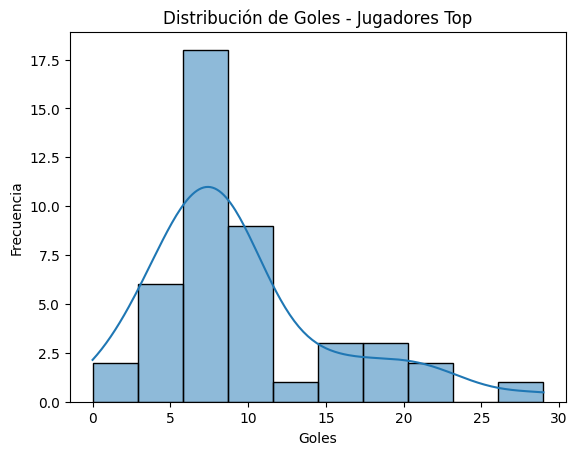

In [167]:
sns.histplot(df_top['Goals'], bins=10, kde=True)
plt.title('Distribución de Goles - Jugadores Top')
plt.xlabel('Goles')
plt.ylabel('Frecuencia')
plt.show()


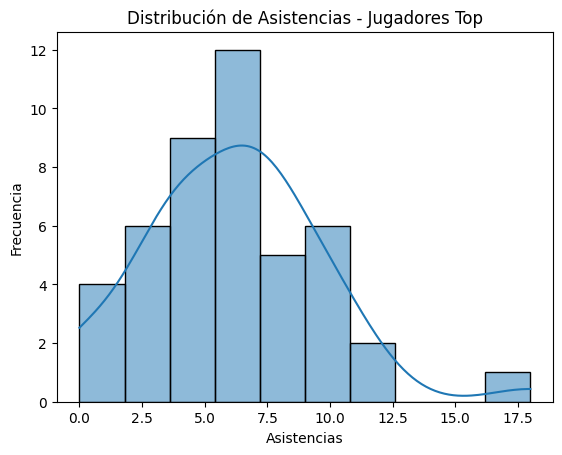

In [168]:
sns.histplot(df_top['Assists'], bins=10, kde=True)
plt.title('Distribución de Asistencias - Jugadores Top')
plt.xlabel('Asistencias')
plt.ylabel('Frecuencia')
plt.show()


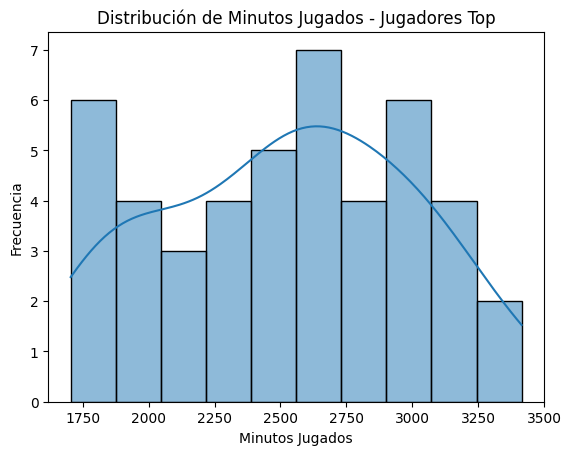

In [169]:
sns.histplot(df_top['Minutes'], bins=10, kde=True)
plt.title('Distribución de Minutos Jugados - Jugadores Top')
plt.xlabel('Minutos Jugados')
plt.ylabel('Frecuencia')
plt.show()


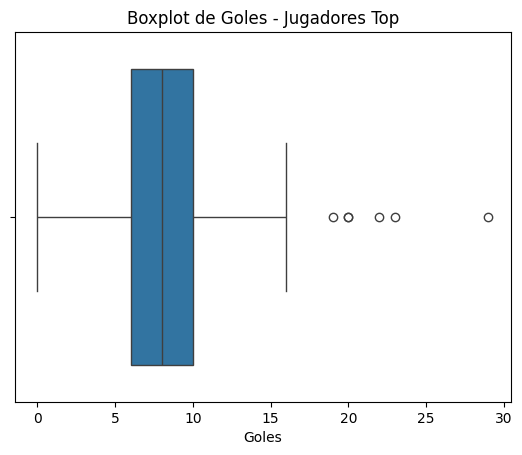

In [170]:
sns.boxplot(x=df_top['Goals'])
plt.title('Boxplot de Goles - Jugadores Top')
plt.xlabel('Goles')
plt.show()


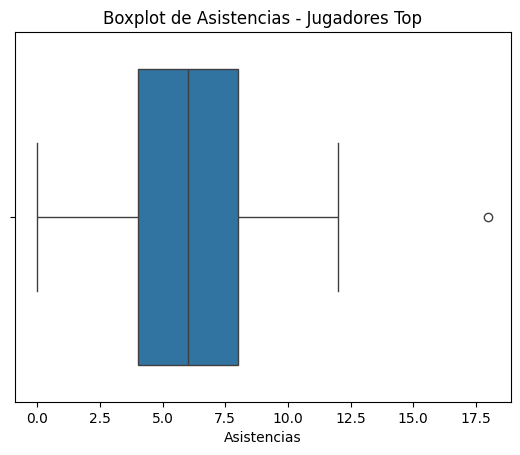

In [171]:
sns.boxplot(x=df_top['Assists'])
plt.title('Boxplot de Asistencias - Jugadores Top')
plt.xlabel('Asistencias')
plt.show()


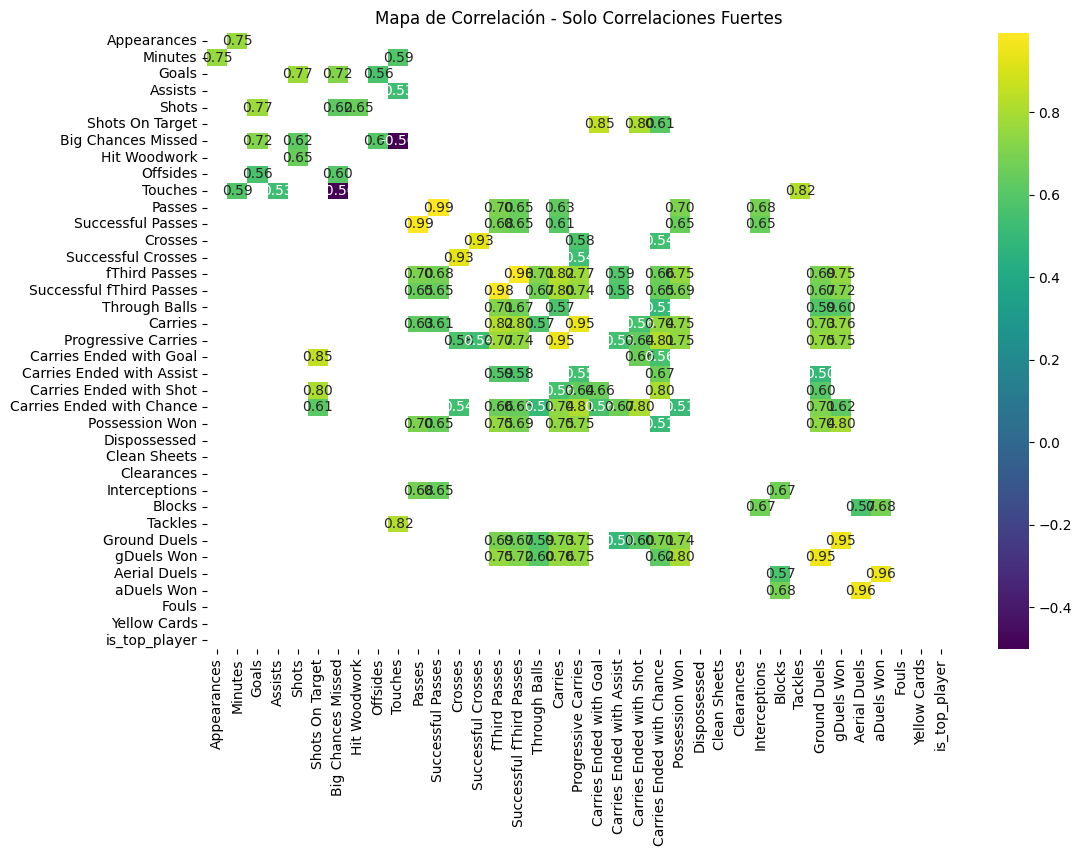

In [172]:
corr = df_top.corr(numeric_only=True)
corr_filtrada = corr[(corr.abs() > 0.5) & (corr != 1)]
plt.figure(figsize=(12, 8))
sns.heatmap(corr_filtrada, annot=True, cmap='viridis', fmt=".2f")
plt.title('Mapa de Correlación - Solo Correlaciones Fuertes')
plt.show()


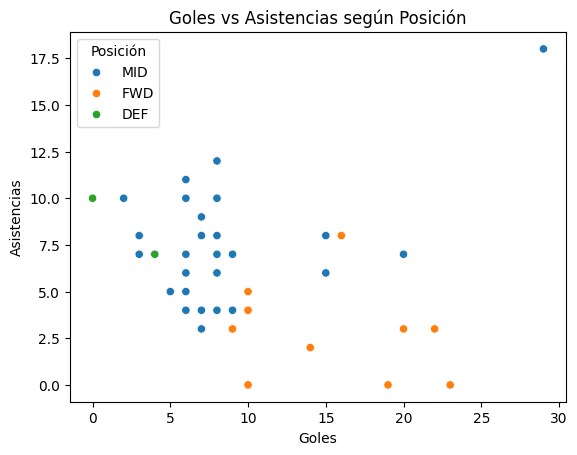

In [173]:
sns.scatterplot(data=df_top, x='Goals', y='Assists', hue='Position')
plt.title('Goles vs Asistencias según Posición')
plt.xlabel('Goles')
plt.ylabel('Asistencias')
plt.legend(title='Posición')
plt.show()


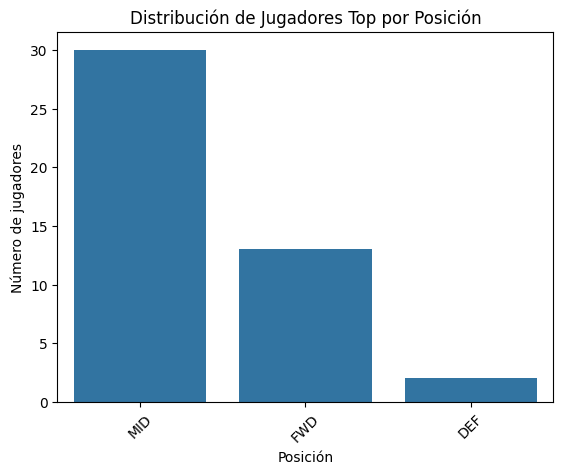

In [174]:
sns.countplot(x='Position', data=df_top, order=df_top['Position'].value_counts().index)
plt.title('Distribución de Jugadores Top por Posición')
plt.xlabel('Posición')
plt.ylabel('Número de jugadores')
plt.xticks(rotation=45)
plt.show()


In [175]:
categorical_cols = ['Position']
numerical_cols = [
    'Goals', 'Assists', 'Shots', 'Shots On Target', 'Big Chances Missed',
    'Minutes', 'Touches', 'Passes', 'Successful Passes', 'Conversion %'
]
target_col = 'is_top_player'

df_features = df_top[categorical_cols + numerical_cols + [target_col]].copy()


In [176]:
df_encoded = pd.get_dummies(df_features, columns=['Position'], drop_first=True)


In [177]:
# Eliminar el símbolo '%' y convertir a float
df_encoded['Conversion %'] = df_encoded['Conversion %'].str.replace('%', '').astype(float)


In [178]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_encoded.drop(columns=[target_col]))


X = pd.DataFrame(features_scaled, columns=df_encoded.drop(columns=[target_col]).columns)
y = df_encoded[target_col]

In [179]:
X.head()  # Muestra las variables transformadas


,Goals,Assists,Shots,Shots On Target,Big Chances Missed,Minutes,Touches,Passes,Successful Passes,Conversion %,Position_FWD,Position_MID
0,-0.601338,1.102813,0.103326,-0.833247,-0.218785,-1.674192,-0.645649,-0.648112,-0.576587,1.724700,-0.637377,0.707107
1,-0.935414,0.247182,-0.664883,0.408860,-1.171559,0.664962,1.053126,-0.285134,-0.336080,0.539792,-0.637377,0.707107
2,-0.267261,-0.608449,-0.381858,-0.056930,-0.218785,-0.470529,-0.665917,-1.391471,-1.482023,-0.052663,-0.637377,0.707107
3,-0.100223,-0.893659,-0.462723,-0.833247,0.892784,-1.378070,-1.119169,-0.934019,-0.938761,-1.237571,1.568929,-1.414214
4,-0.267261,0.247182,0.305487,-0.833247,-0.059989,0.062065,-0.063423,0.115136,0.014776,-0.526626,-0.637377,0.707107


In [180]:
y.value_counts()  # Muestra la distribución de la variable objetivo


is_top_player
1    45
Name: count, dtype: int64

In [181]:
# Mostrar los primeros valores originales
df_encoded['Goals'].head(10)


1      6
3      4
7      8
11     9
13     8
14     3
45     8
46    16
51     3
82    20
Name: Goals, dtype: int64

In [182]:
scaler = StandardScaler()
goals_scaled = scaler.fit_transform(df_encoded[['Goals']])

# Convertir a DataFrame para visualizar
df_goals_scaled = pd.DataFrame({
    'Goals (original)': df_encoded['Goals'].values,
    'Goals (escalado)': goals_scaled.flatten()
})

# Ver primeros 10
df_goals_scaled.head(10)

,Goals (original),Goals (escalado)
0,6,-0.601338
1,4,-0.935414
2,8,-0.267261
3,9,-0.100223
4,8,-0.267261
5,3,-1.102453
6,8,-0.267261
7,16,1.069045
8,3,-1.102453
9,20,1.737198


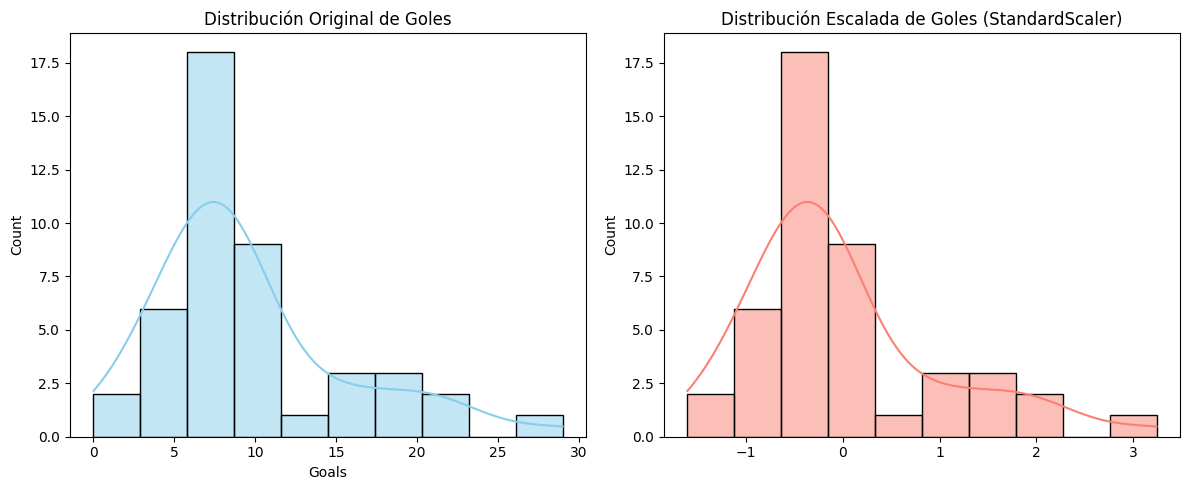

In [183]:

plt.figure(figsize=(12, 5))

# Original
plt.subplot(1, 2, 1)
sns.histplot(df_encoded['Goals'], bins=10, kde=True, color='skyblue')
plt.title('Distribución Original de Goles')

# Escalado
plt.subplot(1, 2, 2)
sns.histplot(goals_scaled.flatten(), bins=10, kde=True, color='salmon')
plt.title('Distribución Escalada de Goles (StandardScaler)')

plt.tight_layout()
plt.show()


In [184]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [185]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


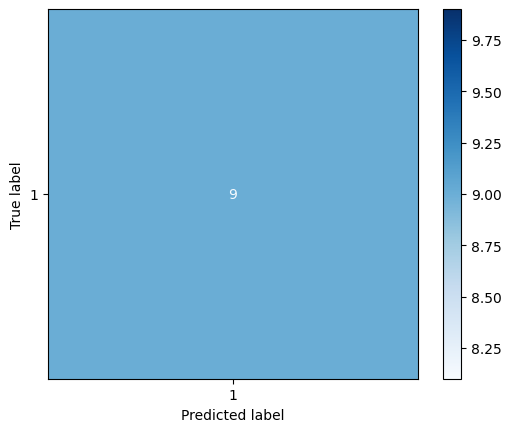

In [186]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Mostrar matriz de confusión
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, cmap='Blues')

In [187]:
metrics_df = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'Valor': [accuracy, precision, recall, f1]
})
metrics_df

,Métrica,Valor
0,Accuracy,1.0
1,Precision,1.0
2,Recall,1.0
3,F1-score,1.0


#### Elegimos Random Forest porque ofrece un excelente equilibrio entre rendimiento y simplicidad. Es especialmente efectivo en conjuntos de datos pequeños como este (45 jugadores top), y maneja bien la mezcla de variables categóricas codificadas y numéricas. Además, tiene buena capacidad de generalización y permite interpretar la importancia de las características.
